<hr> 

# Trajectory Sub Segment Analysis
author, date = p.caldas@fct.unl.pt, May 2021 Version

<hr>

### Import basics 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import gridspec
import seaborn as sns
import sys
import os 
from scipy.spatial.distance import cdist, pdist, mahalanobis
from functools import reduce
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from scipy.spatial import ConvexHull

### Functions to Measure Directionality

In [4]:
def read_trackmate_xml_tracks(xml_file):
    """Reads tracks from trackmate xml track file and converts into a user-friendly DataFrame """
    from xml.etree import cElementTree as ET
    tracks = ET.parse(xml_file)
    frame_interval = float(tracks.getroot().attrib["frameInterval"])
    n_tracks = float(tracks.getroot().attrib["nTracks"])
    
    attributes = []
    for ti, track in enumerate(tracks.iterfind('particle')):
        for spots in track.iterfind('detection'):
            attributes.append([ti, int(spots.attrib.get('t')),
                                   float(spots.attrib.get('x')),
                                   float(spots.attrib.get('y'))])

    track_table = pd.DataFrame(attributes, columns=['TRACK_ID','FRAME','POSITION_X','POSITION_Y'])
    return track_table, frame_interval, n_tracks

def FilterTracks(traj_table, minlen):
    '''filter tracks shorter than minlen, in frames'''
    
    traj_table = traj_table.groupby('TRACK_ID').filter(lambda track: track.TRACK_ID.count() > minlen)
    
    # create a dictionary to attribute a new number to each track ID
    new_ids = {}
    for i, value in enumerate(traj_table.TRACK_ID.unique()):
        new_ids[value] = i
    
    # replace existent IDs with new ID's using the dicitonary above
    traj_table['TRACK_ID'].replace(new_ids, inplace = True)
    
    # reset index (just in case)
    traj_table.reset_index(drop = True, inplace = True)
    
    # THIS WAS SUPER SMART BTW!
    return traj_table

def ComputeDirectionality(track_table, coord = ['POSITION_X','POSITION_Y']):
    '''estimates distance, displacement and directionality for a given track '''

    steps = []
    
    for frame in range(1,len(track_table)):
        step_dist = np.linalg.norm(track_table[coord].iloc[frame] - (track_table[coord].iloc[frame-1]))
        steps.append(step_dist)

    displacement = np.linalg.norm(track_table[coord].iloc[0] - track_table[coord].iloc[-1])
    distance = np.sum(steps)
    directionality = displacement/np.sum(steps)
    
    return distance, displacement, directionality

def ComputeLifetime(trajectory, frame_rate, col = 'FRAME'):
    """computes track duration of a given track
    col: column name with frame number """
    
    return (trajectory[col].iloc[-1] - trajectory[col].iloc[0]) * frame_rate

def ComputeInstantVelocity(trajectory, frame_interval, coord = ['POSITION_X','POSITION_Y']):
    """computes instant velocity of each step along a given track"""
    
    velo = (trajectory[coord] - trajectory[coord].shift(1)).dropna()
    instant_velo = np.sqrt((velo[coord] ** 2).sum(1)) / frame_interval
    
    return instant_velo

def color_pick(p, colors = ['steelblue','orange','crimson']):
    if p >= 1.2:
        color = colors[0]
    elif p > 0.8 and p < 1.2:
        color = colors[1]
    else:
        color = colors[2]
    return color

def ComputeMSD(trajectory, frame_interval, coords = ['POSITION_X','POSITION_Y'], clip_fit = 0.5):
    """Compute MSD for one trajectory; frame_interval: in seconds; coords: in microns"""
    
    msd_curve = []
    n_shifts = len(trajectory)
    
    for shift in range(1, n_shifts):
        diffs = abs(trajectory[coords] - trajectory[coords].shift(-shift))
        msd = np.square(diffs.dropna()).sum(axis=1)
        msd_curve.append(msd.mean())  
    
    taus = np.array(range(1,n_shifts)) * frame_interval
    
    # fit linear equation to find the scalling exponent (alpha)
    
    np.insert(taus, 0, 0) 
    np.insert(msd_curve, 0,0)
    
    clip = int(len(msd_curve) * clip_fit)
    
    eq_linear = lambda t, alpha, d: alpha * t + d
    (alpha, d), cov1 = curve_fit(eq_linear, np.log(taus[:clip]), np.log(msd_curve[:clip]), p0 = (0.5,0.5), 
                                                                                    bounds= ([0, -np.inf],[np.inf,np.inf]))
    
    # fit to a parabola with a diffusion (D) and velocity (V) component if alpha >> 1 (directed motion)
        
    if alpha >= 1.2:

        mode = 'directed'

        eq_parabola = lambda t, D, V: 4*D*t + ((V**2) * (t**2))
        
        msd_params, cov_vel = curve_fit(eq_parabola, taus[:clip], msd_curve[:clip], p0 = (0.5,0.5),
                                                             bounds= ([0, 0],[np.inf,np.inf]))
        # return attributes for active transport
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_parabola(taus_fit, *msd_params)        
    
    # fit to a linear equation with only a diffusion (D) component if alpha is around 1 (Brownian motion)
    
    elif alpha > 0.6 and alpha < 1.2:

        mode = 'random'

        eq_linear2 = lambda t, D: 4*D*t
        msd_params, cov_dif = curve_fit(eq_linear2, taus[:clip], msd_curve[:clip], p0 = 0.5, bounds= (0, np.inf))    

        # return attributes for Brownian diffusion
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_linear2(taus_fit, *msd_params)

    # fit to a linear equation with only a diffusion (D) component if alpha is around 1 (Brownian motion)

    else:
        mode = 'confined'

        eq_confined = lambda t,D,R: (R**2) * (1 - np.exp(-(4*D*t)/(R**2)))
        msd_params, cov_conf = curve_fit(eq_confined, taus[:clip], msd_curve[:clip],
                                        p0 = (0.5,0.5), bounds= ([0,0],[np.inf, np.inf]))    

        # return attributes for confned diffusion
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_confined(taus_fit, *msd_params)
        
    return taus, msd_curve, taus_fit, msd_fit, alpha, msd_params, mode

### Read XML data - Filter Tracks
- filter short tracks (less than n frames)

In [5]:
file = 'data/trajectories/FtsA WT_Exp3_114ms_p3.xml'

table, rate, n_tracks = read_trackmate_xml_tracks(file)
table = FilterTracks(table, 30)

'{} tracks after filtering'.format(len(table.TRACK_ID.unique()))

'440 tracks after filtering'

In [6]:
# Particles Simulated
# track = pd.read_csv('data/traj_dir.txt')

track with 63 steps


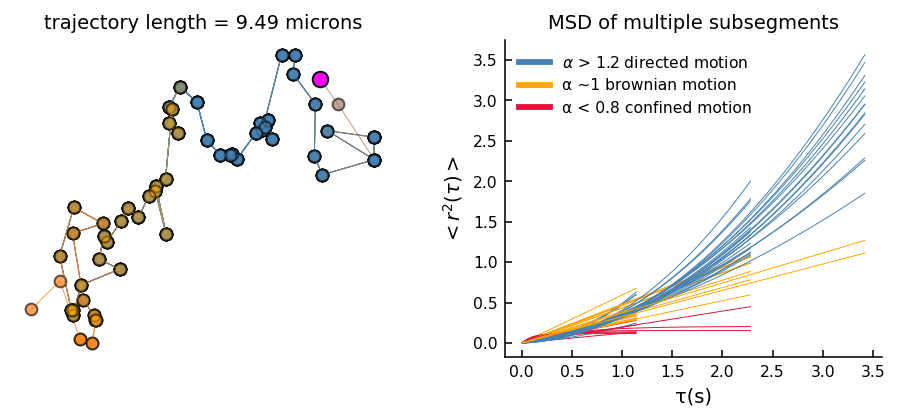

In [7]:
# pick data set to analyze; pick a track number
data = table
frame_interval = rate
i = 214

# track selection
track = data[data.TRACK_ID == i]
print('track with {} steps'.format(len(track)))

# run multiple window_size and compute the parameters
windows = [10, 20, 30]

# tables to save parameters
alphas = []
euc_dists = [] # average euclidean distances
phis = [] # directionality ratio

# plot stuff
fig, ax = plt.subplots(1,2, figsize = (8,3), dpi = 140)
plt.subplots_adjust(wspace = 0.3)

for i, window_size in enumerate(windows, start = 1):
    
    print('rolling window {0} : {1:.3} sec'.format(i, window_size * frame_interval), end="\r")
    
    for window in np.arange(0, track.shape[0] - window_size, 2):
       
        X = track.POSITION_X.iloc[window: window + window_size + 1]
        Y = track.POSITION_Y.iloc[window: window + window_size + 1]

        segment = pd.DataFrame([X,Y]).T # segment to analyze
        
        # msd analysis to find scalling factor (alpha) of each segment
        taus, msds, taus_fit, msds_fit, alpha, msd_params, mode = ComputeMSD(segment, frame_interval, clip_fit = 0.8)
        alphas.append(alpha)
        
        # plot trajectory
        ax[0].plot(X,Y, '-o', lw = 0.5, markeredgecolor = 'black', color = color_pick(alpha), alpha = 0.3)
        ax[0].set_xlabel('X ($\mu m$)'); ax[0].set_ylabel('Y ($\mu m$)')
        #ax[0].set_aspect(aspect = 'equal')
        ax[0].axis('off')
        
        #ax[1].plot(taus, msds, color = 'gray')
        ax[1].plot(taus_fit, msds_fit, lw= 0.5, color = color_pick(alpha))
        ax[1].set_ylabel('$<r^2(\u03C4)>$'); ax[1].set_xlabel('\u03C4(s)')
        ax[1].set_title('MSD of multiple subsegments', fontsize = 10)
        
        # compute average euclidean distance (delta_d)
        euc_dist_avg = np.mean(pdist(segment.values))
        euc_dists.append(euc_dist_avg)
        
        # compute direcitonality ratio for each segment
        directionality = ComputeDirectionality(segment)[-1]
        phis.append(directionality)
        
#draw initital position of the trajectory
ax[0].plot(track.POSITION_X.iloc[0], track.POSITION_Y.iloc[0], 'o', markerfacecolor = 'magenta', markeredgecolor = 'black', markersize = 8)
ax[0].set_title('trajectory length = {:4.3} microns'.format(ComputeDirectionality(track)[0]), fontsize = 10)

# deal with legends for MSD plot
from matplotlib.lines import Line2D
colors = ['steelblue','orange','crimson']
lines  = [Line2D([],[], color = c, linewidth = 3, linestyle = '-') for c in colors]
labels = ['$\u03B1$ > 1.2 directed motion', '\u03B1 ~1 brownian motion','\u03B1 < 0.8 confined motion']
ax[1].legend(lines, labels, loc = 0 , frameon = False, fontsize = 8);

# axis format
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params(direction = 'in', top=False, right = False, labelsize = 8)
#ax[1].set_ylim([0, 1.4]);

### Plot Distribuition of Parameters 

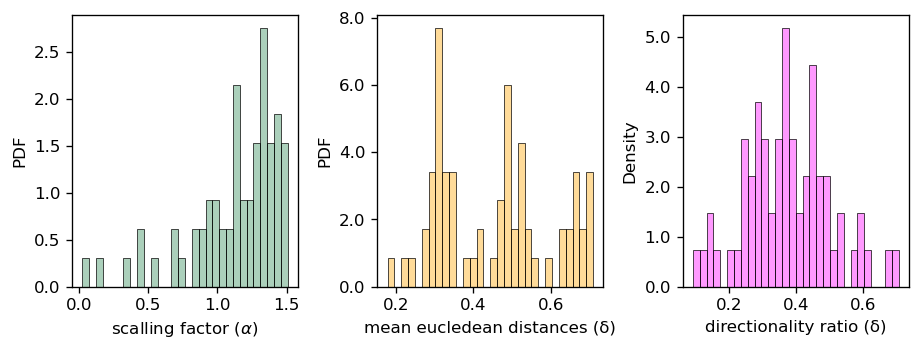

In [8]:
fig = plt.figure(figsize = (9,3), dpi = 120)
plt.subplots_adjust(wspace = 0.35)

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

# alpha distribution
sns.histplot(alphas, ax = ax1, bins = 30, alpha = 0.4, edgecolor = 'black', color = 'seagreen', stat='density')

ax1.set_xlabel('scalling factor ($\u03B1$)'); ax1.set_ylabel('PDF');
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));

# delta distribution
sns.histplot(euc_dists, ax = ax2, bins = 30, alpha = 0.4, edgecolor = 'black', color = 'orange', stat='density')

ax2.set_xlabel('mean eucledean distances (\u03B4)'); ax2.set_ylabel('PDF');
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));

# phi distribution
sns.histplot(phis, ax = ax3, bins = 30, alpha = 0.4, edgecolor = 'black', color = 'magenta', stat='density')

ax3.set_xlabel('directionality ratio (\u03B4)'); ax2.set_ylabel('PDF');
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));

### Trajectory Cage Size: Fit Elipse do 2D points

In [9]:
def FitElipse(track_table, X='POSITION_X', Y = 'POSITION_Y'):
    '''Fits and elipse around all data points'''
    
    # get convex hull for data points
    hull = ConvexHull(track_table) 
    
    # use hull vertices to get area aroung the data points
    x = track_table.reset_index(drop = True).iloc[hull.vertices].POSITION_X
    y = track_table.reset_index(drop = True).iloc[hull.vertices].POSITION_Y
    
    # smooth area around the data points with an elipse
    
    xmean, ymean = x.mean(), y.mean()
    x -= xmean
    y -= ymean
    U, S, V = np.linalg.svd(np.stack((x, y)))

    tt = np.linspace(0, 2*np.pi, 1000)
    circle = np.stack((np.cos(tt), np.sin(tt)))    # unit circle
    transform = np.sqrt(2/len(y)) * U.dot(np.diag(S))   # transformation matrix
    fit = transform.dot(circle) + np.array([[xmean], [ymean]])
    
    return fit, hull.volume

### Visualize cage for last segment above

'31 steps ; area 0.624 microns'

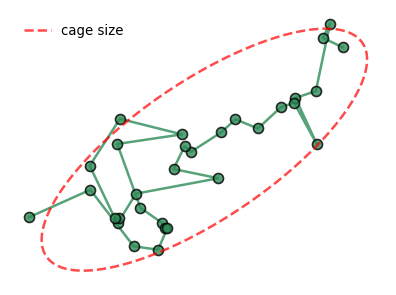

In [10]:
cage, cage_area = FitElipse(segment)

fig = plt.figure(figsize = (4,3), dpi = 120)
plt.subplots_adjust(wspace = 0.35)

plt.plot(segment.POSITION_X, segment.POSITION_Y, '-o', color = 'seagreen', markeredgecolor = 'black', alpha = 0.8);
plt.plot(cage[0, :], cage[1, :], '--r', alpha = 0.7, label = 'cage size')
plt.legend(frameon = False, fontsize = 8, loc = 0)
plt.axis('off')

'{0} steps ; area {1:.3} microns'.format(segment.shape[0], cage_area)

### SubSegment Motion Classification using Cage Size

In [149]:
def MotionMatrix(track, coords = ['POSITION_X','POSITION_Y'], clip = 0.6, windows = [10, 15, 20, 30]):
    
    ### quick fix to overcome runtime warnings with double scalars
    contains_zeros = track[coords].isin([0]).sum().sum()
    
    ### quick fix to overcome memory issues with stuck particles
    # some tracks have duplicated coordinates --> here we discard duplicated lines, keeping only the first ocurrence
    
    track = track[~track.duplicated(['POSITION_X', 'POSITION_Y'])]    
    track['FRAME'] = np.arange(track['FRAME'].iloc[0], track['FRAME'].iloc[0] + len(track['FRAME']))
        
    if contains_zeros == 0: #normal procedure
            
        alpha_cols = []
        phis_cols  = []
        cage_cols  = []
        
        step = 4
        
        for window_size in windows:
            
            for window in np.arange(0, track.shape[0] - window_size, step):

                X = track.POSITION_X.iloc[window: window + window_size + step]
                Y = track.POSITION_Y.iloc[window: window + window_size + step]

                segment = pd.DataFrame([X,Y]).T

                # msd analysis to find scalling factor (alpha) of each segment
                taus, msds, taus_fit, msds_fit, alpha, msd_params, mode = ComputeMSD(segment, frame_interval, clip_fit = clip)

                # compute directionality ratio (phi)
                phis = ComputeDirectionality(segment)[-1]

                #compute cage area of each segment
                cage, cage_area = FitElipse(segment)
                
                # add parameters to respective lists
                alpha_segment = segment.copy()
                alpha_segment['alpha ' + str(window)] = alpha
                alpha_cols.append(alpha_segment.astype('float64'))

                phis_segment = segment.copy()
                phis_segment['phi ' + str(window)] = phis
                phis_cols.append(phis_segment.astype('float64'))
                
                cage_segment = segment.copy()
                cage_segment['cage ' + str(window)] = cage_area
                cage_cols.append(cage_segment.astype('float64'))
                
        #alpha_cols = np.array(alpha_cols, dtype = 'float32')
        
        # create matrix for each parameter
        alpha_matrix = reduce(lambda X,Y: pd.merge(X,Y, on = coords, how = 'outer'), alpha_cols)
        phi_matrix   = reduce(lambda X,Y: pd.merge(X,Y, on = coords, how = 'outer'), phis_cols)
        cage_matrix   = reduce(lambda X,Y: pd.merge(X,Y, on = coords, how = 'outer'), cage_cols)
        
        #print('dealing with delta parameters ... ')
        #delta_matrix   = reduce(lambda X,Y: pd.merge(X,Y, on = coords, how = 'outer'), delta_cols)

        # rename columns with the same name (useful for the next step)
        col_names_alpha = alpha_matrix.iloc[:,2:].shape[1] * ['alpha']
        alpha_matrix.columns = coords + col_names_alpha

        col_names_phi = phi_matrix.iloc[:,2:].shape[1] * ['phi']
        phi_matrix.columns = coords + col_names_phi
        
        col_names_cage = cage_matrix.iloc[:,2:].shape[1] * ['cage']
        cage_matrix.columns = coords + col_names_cage

        # merge everything into a single matrix

        matrix_merged = pd.merge(alpha_matrix, phi_matrix, on = coords, how = 'outer')
        matrix_merged = pd.merge(matrix_merged, cage_matrix, on = coords, how = 'outer')
    
    else:
        print('double scalar problems, moving on')
        
    return matrix_merged
            
def alpha_score(alpha, cage_area):
    
    if alpha >= 1.2: 
        
        mode = 'directed'; score = 1
        
    if alpha < 1.2: 
        
        mode = 'random'; score = 1
        
        if cage_area < 0.2: 
            
            mode = 'confined'; score = 1
        
    #if alpha <= 0.8: 
    #    mode = 'confined'; score = 1
            
    return mode, score
   
def phi_score(phi, cage_area):
    
    '''if directionality (phi) is low, vote for directed motion, otherwise is browninan.
    if average euclidean distance is small, it's probably a confined motion '''
    
    if phi >= 0.50:
        mode = 'directed'; score = 1
    
    if phi < 0.50: 
        mode = 'random'; score = 1
        
        if cage_area < 0.2:
            mode = 'confined'; score = 1
        
    #if phi < 0.20: mode = 'confined'; score = 1
        
    return mode, score

# def cage_score(cage_area, alpha):
    
#     if alpha < 1.2: 
        
#         if cage_area < 2: mode = 'confined'; score = 2
#         elif cage_area > 2: mode = 'random'; score = 1
            
#     elif alpha >= 1.2: mode = 'directed'; score = 0
        
#     return mode, score

def BetaMatrix(MotionMatrix, par1 = 'alpha', par2 = 'phi', par3='cage'):
    
    '''return a score based on a voting system for each data point'''
    
    table = MotionMatrix
    all_beta_matrix = []
    
    for alphas, phis, cages in zip(table[par1].iterrows(), table[par2].iterrows(), table[par3].iterrows()):
        
        # create a beta_matrix for each time point
        beta_matrix = defaultdict(list)
        beta_matrix.update({'confined':[],'random':[],'directed':[]})
        
        for alpha, cage in zip(alphas[1].dropna(), cages[1].dropna()):
            
            mode, score = alpha_score(alpha, cage)
            beta_matrix[mode].append(score)
            
        for phi, cage in zip(phis[1].dropna(), cages[1].dropna()):
            
            mode, score = phi_score(phi, cage)
            beta_matrix[mode].append(score)
        
#         for cage in cages[1].dropna():
            
#             mode, score = cage_score(cage, alpha)
#             beta_matrix[mode].append(score)
            
        all_beta_matrix.append(beta_matrix) 
    
    # HERE we should introduce some sort of correction for ambiguous transition points
    # for isntance single data points with their own mode of motion
    # e.g the ends of the trajectories have a different mode of motion --> currently I discard the ends from the analysis
    # should be fixed here ... new ideas ... let neighboor influence the decision?
           
    return all_beta_matrix # this is a list of dictionaries

def BetaScore(beta_matrix_dict):
    ''' finds the most voted mode for each datapoint in the dictionary'''
    
    beta_scores = []
    
    for i in beta_matrix_dict:
        
        n_votes = sum(list(map(len, i.values())))
        b_sum = list(map(sum, i.values()))     # sum of the votes in each parameter
           
        mode, votes = max(i, key = i.get), max(b_sum)       
        beta_score = votes/n_votes
        beta_scores.append([mode, beta_score])
    
    return pd.DataFrame(beta_scores, columns = ['mode','beta_score'])

def MotionClassification(track, coords = ['POSITION_X','POSITION_Y']):
    '''apply all the steps above to a single track'''
    
    scores = BetaScore(BetaMatrix(MotionMatrix(track)))            
    return pd.concat([track[coords].reset_index(drop=True), scores],axis = 1)

def PlotMotionClassification(traj_score, col = 'mode'):

    X = traj_score.POSITION_X 
    Y = traj_score.POSITION_Y

    X_d = traj_score[traj_score[col] == 'directed'].POSITION_X
    Y_d = traj_score[traj_score[col] == 'directed'].POSITION_Y

    X_b = traj_score[traj_score[col] == 'random'].POSITION_X
    Y_b = traj_score[traj_score[col] == 'random'].POSITION_Y

    X_c = traj_score[traj_score[col] == 'confined'].POSITION_X
    Y_c = traj_score[traj_score[col] == 'confined'].POSITION_Y

    fig = plt.figure(figsize = (4,3), dpi = 120)

    plt.plot(X[0],Y[0], '*', markersize = 12, c= 'green');
    plt.plot(X,Y, '--', lw = 0.8, c= 'gray');

    plt.plot(X_d,Y_d, 'o', lw = 1, markeredgecolor = 'black', color = color_pick(1.5), alpha = 0.9);
    plt.plot(X_b,Y_b, 'o', lw = 1, markeredgecolor = 'black', color = color_pick(1.0), alpha = 0.9);
    plt.plot(X_c,Y_c, 'o', lw = 1, markeredgecolor = 'black', color = color_pick(0.5), alpha = 0.9);
    
    # add cage area (confined movement) to plot
    # cage, cage_area = FitElipse(traj_score[traj_score[col] == 'confined'][['POSITION_X','POSITION_Y']])
    # plt.plot(cage[0, :], cage[1, :], '--r', alpha = 0.7, label = 'cage size')
    
    plt.axis('off'); #plt.axis('equal')
    
    # deal with legend
    from matplotlib.lines import Line2D
    colors = ['steelblue','orange','crimson']
    lines  = [Line2D([],[], color = c, linewidth = 3, linestyle = '-') for c in colors]
    labels = ['directed', 'random','confined']
    plt.legend(lines, labels, loc = 0 , bbox_to_anchor = (1,1), frameon = False, fontsize = 8);

def ComputeModeMSD(trajectory, frame_interval, mode, coords = ['POSITION_X','POSITION_Y'], clip_fit = 0.5):
    """Compute MSD for one trajectory; frame_interval: in seconds; coords: in microns"""
    
    msd_curve = []
    n_shifts = len(trajectory)
    
    for shift in range(1, n_shifts):
        diffs = abs(trajectory[coords] - trajectory[coords].shift(-shift))
        msd = np.square(diffs.dropna()).sum(axis=1)
        msd_curve.append(msd.mean())  
    
    taus = np.array(range(1,n_shifts)) * frame_interval
    clip = int(len(msd_curve) * clip_fit)
    
    # fit to a parabola with a diffusion (D) and velocity (V) component if mode is directed motion
        
    if mode == 'directed':

        eq_parabola = lambda t, D, V: 4*D*t + ((V**2) * (t**2))
        
        msd_params, cov_vel = curve_fit(eq_parabola, taus[:clip], msd_curve[:clip], p0 = (0.5,0.5),
                                                             bounds= ([0, 0],[np.inf,np.inf]))
        # return attributes for active transport
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_parabola(taus_fit, *msd_params)        
    
    # fit to a linear equation with only a diffusion (D) component if mode is Brownian motion
    
    if mode == 'random':

        eq_linear2 = lambda t, D: 4*D*t
        msd_params, cov_dif = curve_fit(eq_linear2, taus[:clip], msd_curve[:clip], p0 = 0.5, bounds= (0, np.inf))    

        # return attributes for Brownian diffusion
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_linear2(taus_fit, *msd_params)

    # fit to a linear equation with only a diffusion (D) component if mode is confined/subdiffusion
    
    if mode == 'confined':

        eq_confined = lambda t,D,R: (R**2) * (1 - np.exp(-(4*D*t)/(R**2)))
        msd_params, cov_conf = curve_fit(eq_confined, taus[:clip], msd_curve[:clip],
                                        p0 = (0.5,0.5), bounds= ([0,0],[np.inf, np.inf]))    

        # return attributes for confned diffusion
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_confined(taus_fit, *msd_params)
        
    return msd_params

def ComputeSubSegmentStats(traj_score, frame_interval, col = 'mode'):
    '''for each segment fit an msd again to retrieve parameters'''
    
    import warnings
    warnings.filterwarnings("ignore")
    
    transition_points = [0]
    
    for i, row in traj_score.iloc[:-1].iterrows():
        if traj_score[col].iloc[i+1] != traj_score[col].iloc[i]:
            transition_points.append(i)
    
    # if there's no transition points, the list will contain only first and last point
    transition_points.append(len(traj_score)) 
    
    stats = []

    for i, pos in enumerate(transition_points[:-1]):
        
        # subsegment using transition points
        sub_segment = traj_score.iloc[transition_points[i]:transition_points[i+1]]
        
        # apply stats only if segment has at least 5 steps
        if len(sub_segment) > 5:
            
            mode = sub_segment['mode'].iloc[1]
            
            print('motion:', mode, end = '\r')
            
            # perform msd analysis for each segment
            
            msd_parameters = ComputeModeMSD(traj_score.iloc[transition_points[i]:transition_points[i+1]], frame_interval, mode)
            
            # compute lifetimes
            lifetime = traj_score.iloc[transition_points[i]:transition_points[i+1]].shape[0] * rate 

            # append everything
            # output is mode of diffusion, msd scalling factor alpha, msd parameters for a given model and liftime in seconds
            
            stats.append([mode, msd_params, lifetime])
           
            #stats.append([sub_segment['mode'].iloc[0], lifetime])
            
    if len(transition_points) == 2: 
        print('transition points: {}'.format(None))

    else:
        print('transition points: {}'.format(len(transition_points[1:-1])))
        
    return stats

def extract_confined_lifetimes(stats):
    '''extract lifetime of the confined trajectories from results above, if they exist'''
    lifetimes_confined = [param[-1] for param in stats if param[0] == 'confined']
    lifetimes_confined = np.sum(lifetimes_confined) # sum all lifetimes if more than one segment exists
    
    print('time under confinement : {:.3} sec'.format(lifetimes_confined))
    
    return np.sum(lifetimes_confined)

### Single Track Analysis

'track length = 62 steps'

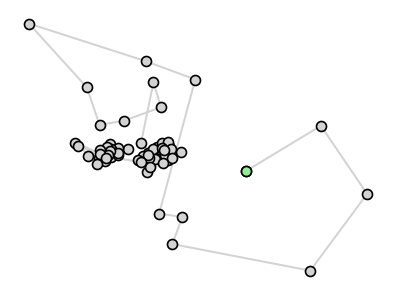

In [153]:
# track number (2, 3, 302
i = 2
track = table[table.TRACK_ID == i]

fig = plt.figure(figsize = (4,3), dpi = 120); plt.axis('off'); #plt.axis('equal')
plt.plot(track.POSITION_X, track.POSITION_Y, '-o', lw = 1.2, markeredgecolor = 'black', color = 'lightgray')
plt.plot(track.POSITION_X.iloc[0], track.POSITION_Y.iloc[0], 'o', lw = 1.2, markeredgecolor = 'black', color = 'lightgreen')

'track length = {} steps'.format(len(track))

### Single Track Submotion Classification

transition points: 1
time under confinement : 6.73 sec


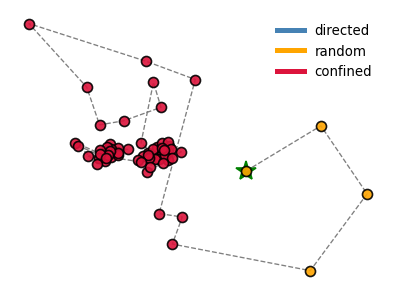

In [154]:
track_segment = MotionClassification(track); PlotMotionClassification(track_segment)
lifetimes = extract_confined_lifetimes(ComputeSubSegmentStats(track_segment, rate))

### Extract Stats from each underlying segment

In [152]:
ComputeSubSegmentStats(track_segment, rate)

transition points: 3


[['random', array([0.08130343]), 3.5340000000000003],
 ['directed', array([0.08130343]), 2.622]]

### Check what is happing under the hood

In [ ]:
MotionMatrixTable = MotionMatrix(track)
#MotionMatrixTable

In [ ]:
BetaMatrixDF = pd.DataFrame(BetaMatrix(MotionMatrixTable))
#BetaMatrixDF

In [138]:
track_segment

<hr>

### Analyze All Tracks - Lifetime Parameter

#### Wrap everything into a function

In [145]:
def AnalyzeAllTracks(table, tracks = -1):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    # truncate number of tracks to analyze; default is -1 to analyze eveything
    if tracks == -1: 
        table = table

    else:
        trunc = table[table['TRACK_ID'] == tracks].index[-1]
        table = table.iloc[:trunc]
       
    # apply all functions
    
    all_tracks_stats = []

    for i, track in table.groupby('TRACK_ID'):
            
            # check if trajectory is just noise (i.e empty tracks)
            
            noise = (track[~track.duplicated(['POSITION_X', 'POSITION_Y'])].shape[0] < 10)
            
            if noise == False:
            
                print('track {}/{}'.format(i, len(table.TRACK_ID.unique())), end = '\r')

                try: # in case something is wrong with a particular track proceeds to the next track

                    track_segment = MotionClassification(track)
                    stats = ComputeSubSegmentStats(track_segment, rate)
                    all_tracks_stats.append(stats)

                except (ValueError, RuntimeError, UnboundLocalError, AttributeError, MemoryError):
                    print("messy track, moving on")
                    pass
    
    return all_tracks_stats

### Apply Function to All Tracks
- default = -1 (all tracks) 
- This might take a while

In [141]:
stats = AnalyzeAllTracks(table, tracks = -1)

transition points: 2
transition points: 2
transition points: None
transition points: None
transition points: None
transition points: 1
transition points: None
transition points: None
transition points: None
transition points: 1
transition points: None
transition points: 1
transition points: 3
double scalar problems, moving on
transition points: None
transition points: None
transition points: 1
transition points: 5
transition points: 2
transition points: 3
transition points: 2
transition points: 4
transition points: None
transition points: None
transition points: 3
transition points: 1
transition points: None
transition points: 3
transition points: 1
transition points: 2
transition points: None
transition points: None
transition points: 2
transition points: 2
transition points: 1
transition points: None
transition points: 4
transition points: 1
transition points: 1
transition points: 5
transition points: 6
transition points: None
transition points: None
transition points: None
transitio

### Extract Info from the Output 
#### Example: Distribution of Lifetimes

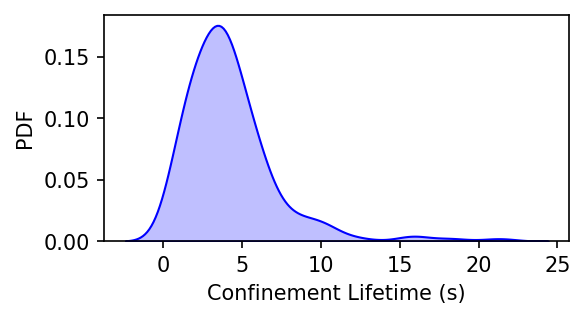

In [163]:
lifetime_confined  = []
lifetime_browninan = []
lifetime_directed  = []

n_confined = []
n_brownian = []
n_directed = []

for i, track in enumerate(stats):
    
    for segment in track:
        if segment[0] == "confined":
            lifetime_confined.append(segment[-1])
            n_confined.append(i) # append track number to count later
            
        if segment[0] == "random":
            lifetime_browninan.append(segment[-1])
            n_brownian.append(i)
            
        if segment[0] == "directed":
            lifetime_directed.append(segment[-1])
            n_directed.append(i)

# Plot lifetime distribution
fig, ax = plt.subplots(figsize = (4,2), dpi = 150)
sns.kdeplot(lifetime_confined, shade = True, color = 'blue')
#sns.histplot(phis, bins = 20, alpha = 0.4, edgecolor = 'black', color = 'blue', ax = ax)
plt.ylabel('PDF'); plt.xlabel('Confinement Lifetime (s)');

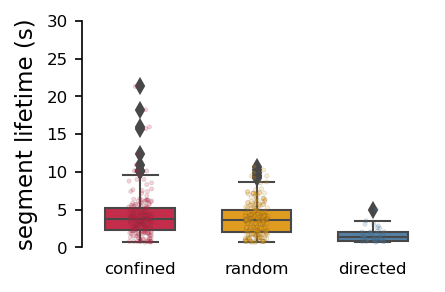

In [171]:
# plot distribution of lifetimes of each motion mode per segment
lifetime_boxes = pd.DataFrame([lifetime_confined, lifetime_browninan, lifetime_directed],
                             index = ['confined','random','directed']).T

fig, ax = plt.subplots(figsize = (3,2), dpi = 150)
mycolors = ['crimson','orange','steelblue']

sns.boxplot(data = lifetime_boxes, ax = ax, palette = mycolors, width = 0.6, linewidth = 1)
sns.stripplot(data = lifetime_boxes, ax = ax, palette = mycolors, size = 2, linewidth=0.3, alpha = 0.2)

# format axes
ax.set_ylabel('segment lifetime (s)', fontsize = 11); # ax1.set_xlabel('type of motion', fontsize = 11);
ax.tick_params(direction = 'out', top=False, right = False, bottom = False, labelsize=8)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['bottom'].set_visible(False)
ax.set_ylim([0, 30]);

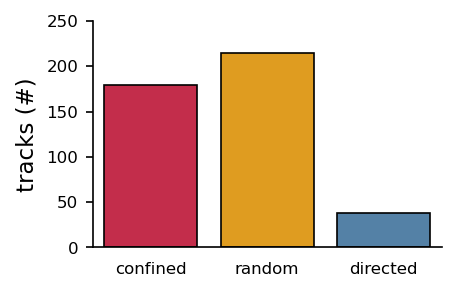

In [174]:
# plot number of tracks showing each type of motion

fig, ax = plt.subplots(figsize = (3,2), dpi = 150)
mycolors = ['crimson','orange','steelblue']

track_motion = pd.DataFrame([len(np.unique(n_confined)), len(np.unique(n_brownian)), len(np.unique(n_directed))],
                            index = ['confined','random','directed']).T

sns.barplot(data = track_motion, ax = ax, palette = mycolors, edgecolor = 'black', linewidth = 0.8, dodge = False)

# fancy stuff
ax.set_ylabel('tracks (#)', fontsize = 11); #ax.set_xlabel('type of motion', fontsize = 11);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.tick_params(direction = 'out', top=False, right = False, bottom = False, labelsize=8)
ax.set_ylim([0,250]);

## Things To Do

- check what else can be useful
- other ways to characterize confinement